In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (20, 10)


In [2]:
#get unique dictionary of team to franchise IDs to merge into following dataframes
teams = pd.read_csv('LahmanData2023\core\Teams.csv')

franch_IDs = []
for team in teams['teamID'].unique():
    franch_IDs.append(teams[teams['teamID'] == team]['franchID'].iloc(0)[0])

franchises = pd.DataFrame(list(zip(teams['teamID'].unique(),franch_IDs)), columns=['teamID','franchID'])

#case sensitive fix for some differences in formatting :(
warbat = pd.read_csv('war_daily_bat.txt')
warbat = warbat[warbat['year_ID'] > 1984]
for a in warbat['team_ID'].unique():
    if not a in list(franchises['teamID']):
        if a in list(franchises['franchID']):
            franchises.loc[len(franchises.index)] = [a,a]
        else:
            franchises.loc[len(franchises.index)] = ['TBR','TBD']



salary = pd.read_csv('LahmanData2023\contrib\Salaries.csv').merge(franchises, on='teamID')
war_batting = pd.read_csv('war_daily_bat.txt').merge(franchises, left_on='team_ID',right_on='teamID')
war_pitching = pd.read_csv('war_daily_pitch.txt').merge(franchises, left_on='team_ID',right_on='teamID')

In [33]:
war_batting.keys()

Index(['name_common', 'age', 'mlb_ID', 'player_ID', 'year_ID', 'team_ID',
       'stint_ID', 'lg_ID', 'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp',
       'runs_field', 'runs_infield', 'runs_outfield', 'runs_catcher',
       'runs_good_plays', 'runs_defense', 'runs_position', 'runs_position_p',
       'runs_replacement', 'runs_above_rep', 'runs_above_avg',
       'runs_above_avg_off', 'runs_above_avg_def', 'WAA', 'WAA_off', 'WAA_def',
       'WAR', 'WAR_def', 'WAR_off', 'WAR_rep', 'salary', 'pitcher', 'teamRpG',
       'oppRpG', 'oppRpPA_rep', 'oppRpG_rep', 'pyth_exponent',
       'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
       'waa_win_perc_def', 'waa_win_perc_rep', 'OPS_plus', 'TOB_lg', 'TB_lg',
       'teamID', 'franchID'],
      dtype='object')

In [3]:
# team_salary_lahman = salary.groupby(['yearID','franchID']).agg(sum).reset_index()
# team_salary_bref_batting = war_batting.groupby(['year_ID','franchID']).agg(sum).reset_index().loc[:,['year_ID','franchID','salary']]
# team_salary_bref_pitching = war_pitching.groupby(['year_ID','franchID']).agg(sum).reset_index().loc[:,['year_ID','franchID','salary']]
# team_salary_concat = team_salary_bref_pitching.merge(team_salary_bref_batting, on = ['year_ID','franchID'])
# team_salary_concat['diff'] = team_salary_concat['salary_x'] - team_salary_concat['salary_y']
# team_salary_concat['percent_diff'] = team_salary_concat['salary_x']/team_salary_concat['salary_y']

In [34]:
team_salary_bref_batting = war_batting.groupby(['year_ID','franchID']).agg(sum).reset_index().loc[:,['year_ID','franchID','salary','WAR']]
team_stats_full = team_salary_bref_batting.merge(teams, left_on=['year_ID','franchID'], right_on=['yearID','franchID'])

playoffs = []
for i in range(len(team_stats_full)):
    if team_stats_full['WCWin'][i] == 'Y' or team_stats_full['DivWin'][i] == 'Y':
        playoffs.append('Y')
    else:
        playoffs.append('N')

team_stats_full['playoffs'] = playoffs

#removing years with incomplete salary statistics, and 1994 which was an incomplete season due to MLB strike
team_stats_full = team_stats_full[team_stats_full['yearID'] > 1984]
team_stats_full = team_stats_full[team_stats_full['yearID'] != 1994]
team_stats_full = team_stats_full[team_stats_full['yearID'] < 2020]
team_stats_full.reset_index(inplace=True)

yearly_average = team_stats_full.groupby('yearID').agg(['mean',np.std]).reset_index().loc[:,['yearID','salary']]
pct_yearly_average = []
for i in range(len(team_stats_full)):
    pct_yearly_average.append(team_stats_full['salary'][i]/yearly_average[yearly_average['yearID'] == team_stats_full['yearID'][i]]['salary'])

team_stats_full['pct_yearly_average'] = pct_yearly_average

### Graphs and Analysis

summary of data:

team_stats_full - stats grouped by team and year 

yearly_average - average salary grouped by year

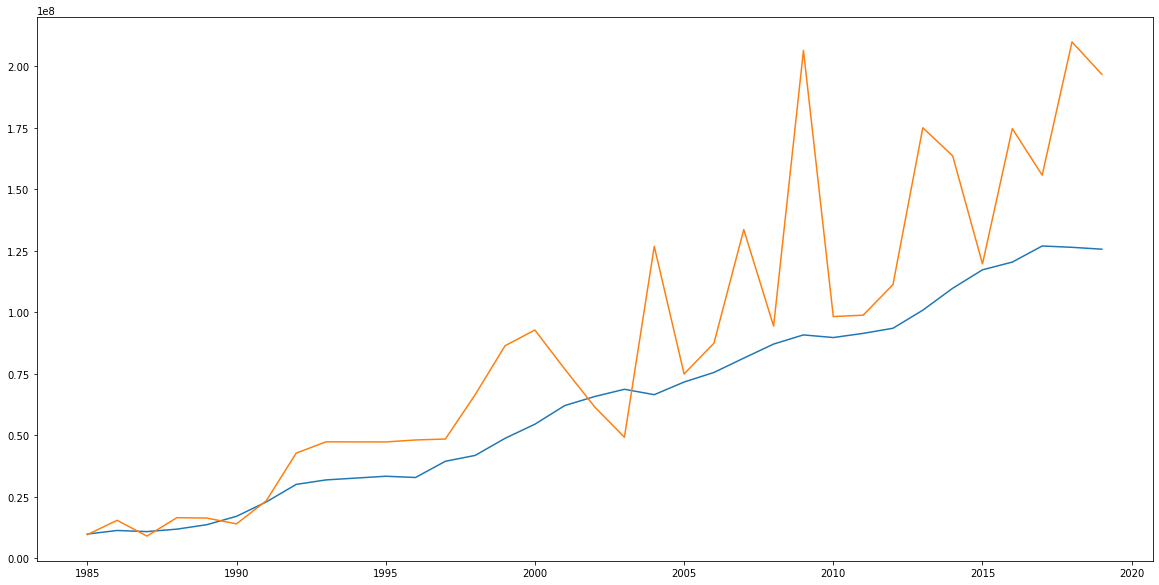

In [6]:
plt.plot(yearly_average['yearID'],yearly_average['salary'])
plt.plot(team_stats_full['yearID'].unique(),team_stats_full[team_stats_full['WSWin'] == 'Y']['salary'])


<AxesSubplot:xlabel='yearID', ylabel='salary'>

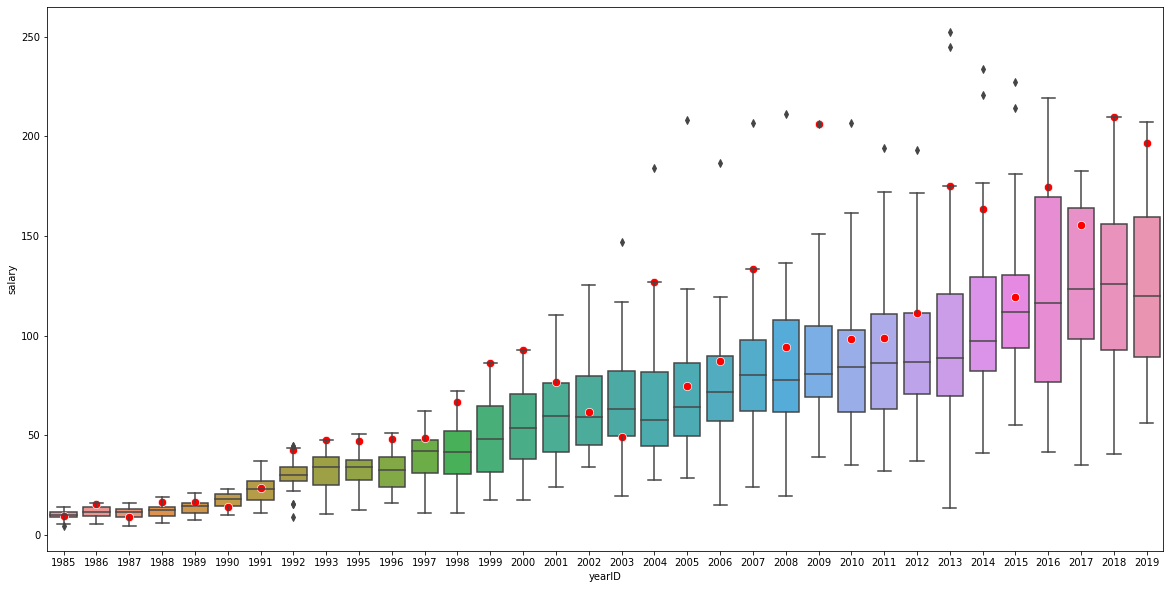

In [49]:
fig, ax = plt.subplots()
sns.boxplot(x = team_stats_full['yearID'],y = team_stats_full['salary']/1000000, ax=ax)
sns.scatterplot(x = team_stats_full['yearID'].unique().astype(str),y = team_stats_full[team_stats_full['WSWin'] == 'Y']['salary']/1000000, s = 70,color='red',ax=ax)
#ax.set_yscale('log')

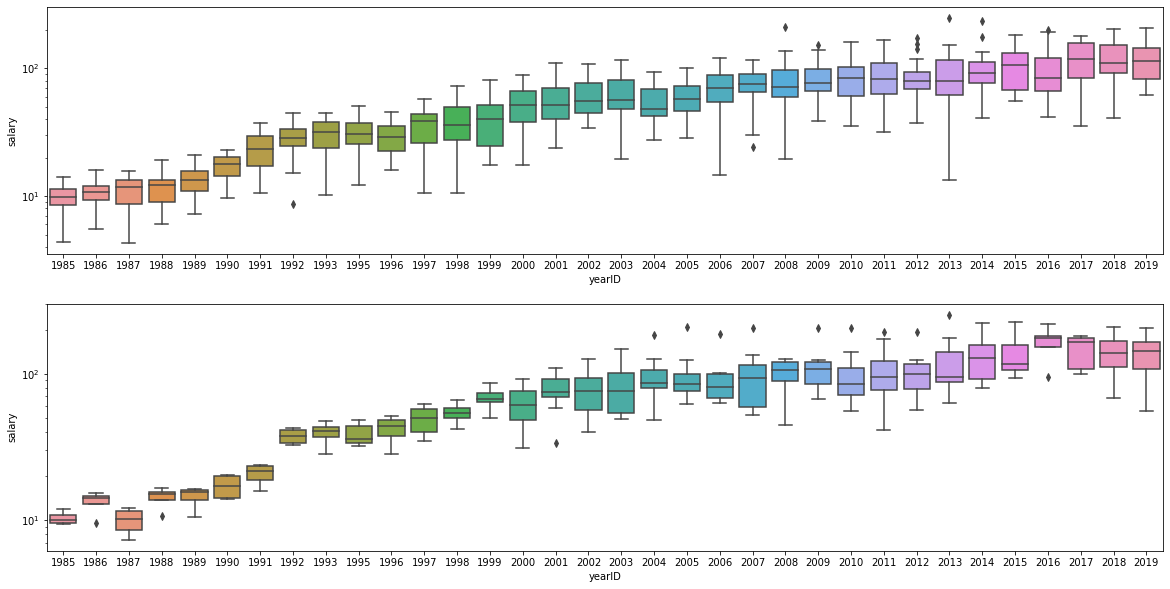

In [31]:
fig, ax = plt.subplots(2,1)
sns.boxplot(x = team_stats_full['yearID'],y = team_stats_full[team_stats_full['playoffs'] == 'N']['salary']/1000000, ax=ax[0])
sns.boxplot(x = team_stats_full['yearID'],y = team_stats_full[team_stats_full['playoffs'] == 'Y']['salary']/1000000, ax=ax[1])
#sns.scatterplot(x = team_stats_full['yearID'].unique().astype(str),y = team_stats_full[team_stats_full['WSWin'] == 'Y']['salary']/1000000, s = 70,color='red',ax=ax[0])
ax[0].set_yscale('log')
ax[1].set_yscale('log')

<AxesSubplot:>

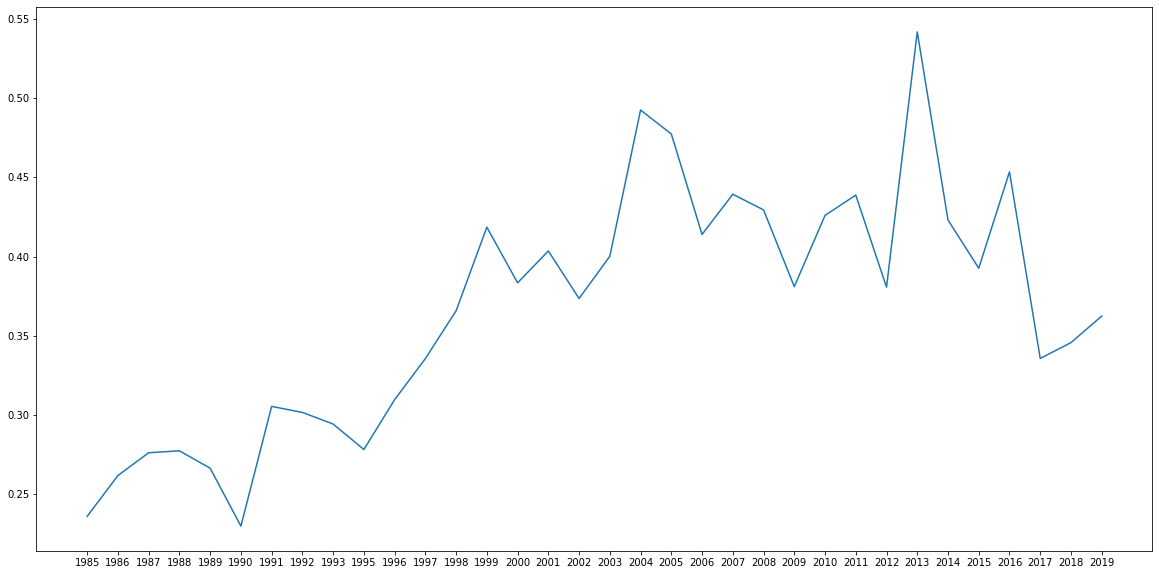

In [20]:
sns.lineplot(x = team_stats_full['yearID'].unique().astype(str),y = yearly_average['salary']['std']/yearly_average['salary']['mean'])

In [40]:
#sns.heatmap([team_stats_full[team_stats_full['yearID'] == 2013]['W'], team_stats_full[team_stats_full['yearID'] == 2013]['salary'], team_stats_full[team_stats_full['yearID'] == 2013]['WAR']])

Text(0, 0.5, 'WAR')

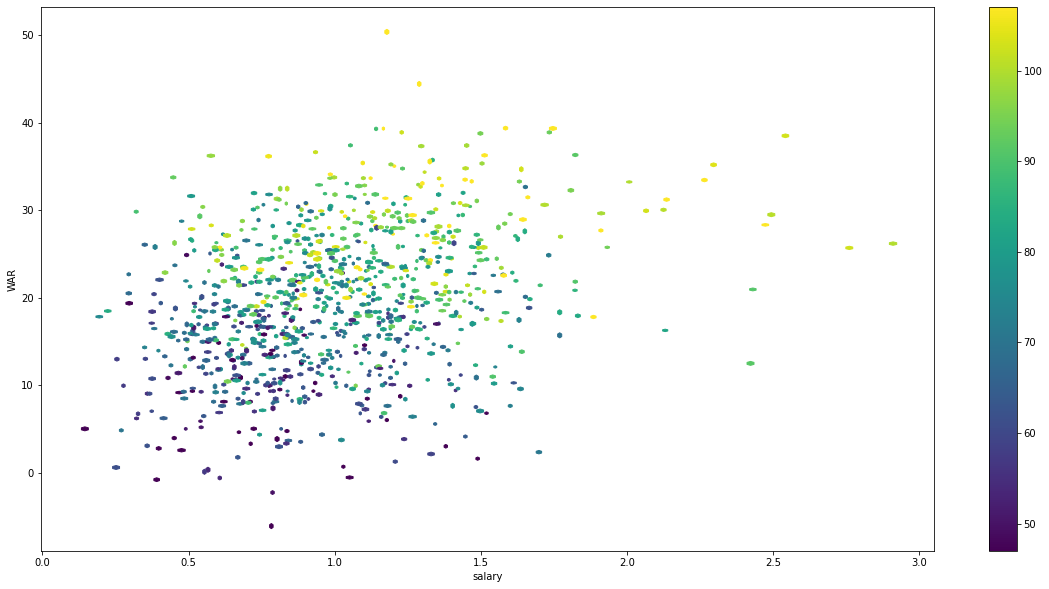

In [50]:
for i,year in enumerate(team_stats_full['yearID'].unique()):
    plt.hexbin(team_stats_full[team_stats_full['yearID'] == year]['salary']/yearly_average['salary']['mean'][i], team_stats_full[team_stats_full['yearID'] == year]['WAR'], C = team_stats_full[team_stats_full['yearID'] == year]['W'] )

plt.colorbar()
plt.xlabel('salary')
plt.ylabel('WAR')